In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [11]:
## All the funcions:

<bound method DataFrame.info of             time     Open     High      Low    Close      Volume
0     2021-01-01    1.510    1.865    1.495    1.847  1125773.54
1     2021-01-02    1.847    2.012    1.752    1.799  1060347.35
2     2021-01-03    1.799    2.808    2.007    2.185  1475936.63
3     2021-01-04    2.185    2.573    2.066    2.491  1543191.05
4     2021-01-05    2.491    2.634    2.145    2.158  1246011.66
...          ...      ...      ...      ...      ...         ...
1363  2024-09-25  152.720  153.880  147.300  147.970  1140072.57
1364  2024-09-26  147.970  158.030  146.590  155.580  1590861.37
1365  2024-09-27  155.580  161.240  154.010  157.640  1503547.66
1366  2024-09-28  157.640  159.400  155.080  156.780   576303.31
1367  2024-09-29  156.780  160.770  155.120  160.010   741062.22

[1368 rows x 6 columns]>


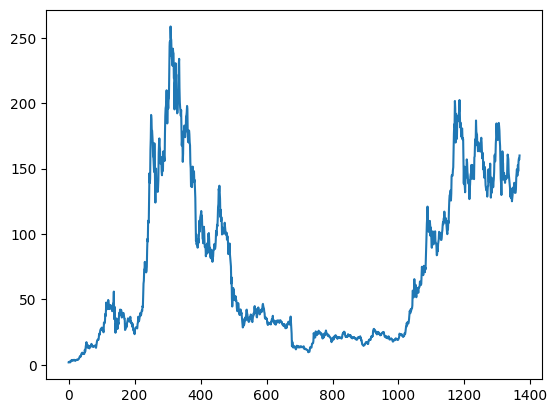

In [ ]:
## Main data import and variables creation

data_frame = pd.read_csv("Solana_daily_data_2021_2024.csv")
print(data_frame.info)

close_data = data_frame.get("Close").tolist()   # Price and the end of the day
time_data = data_frame.get("time").tolist()     # Corresponding days

plt.plot(close_data)